In [15]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering_shadows import render_rays, efficient_sm
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (64, 64)

def normalize_min_max(tensor, new_max=1.0, new_min=0.0):
     return (tensor - tensor.min())/(tensor.max() - tensor.min() + EPSILON)*(new_max - new_min) + new_min



In [2]:
from dotmap import DotMap
    
hparams = {
    'black_and_white': False, 
    'coords_trans': False, 
    'blur': -1, 
    'white_pix': -1, 
}
hparams = DotMap(hparams)
dataset = dataset_dict['efficient_sm'] \
          ('../../datasets/volumetric/results_500_v2_distance_transform_150/', 'val',
           img_wh=img_wh, hparams=hparams)

!ls ./logs-eval/NEW___SIGMA_Nimp_64_64x64_grad_on_light_LN_32_shadowmethod2/epoch\=10.ckpt

Training Image size: (64, 64)
------------
NOTE: self.hparams.coords_trans is set to False 
------------
'./logs-eval/NEW___SIGMA_Nimp_64_64x64_grad_on_light_LN_32_shadowmethod2/epoch=10.ckpt'


In [3]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = './logs-eval/NEW___SIGMA_Nimp_64_64x64_grad_on_light_LN_32_shadowmethod2/epoch=10.ckpt'
# ckpt_path = 'ckpts/exp2/epoch=05.ckpt'

# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [4]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4
perturb =0
noise_std = 0
@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        perturb,
                        noise_std,
                        N_importance=N_importance,
                        chunk=chunk, # chunk size is effective in val mode
                        white_back = True, 
                        were_gradients_computed=False)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [5]:
sample = dataset[1]
print(sample.keys())
# raise
rays = sample['rays'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.2761116027832031


In [27]:
results, results['opacity_fine'].shape, 

(defaultdict(list,
             {'depth_coarse': tensor([109.4837, 111.8917, 110.9135,  ..., 111.7923, 112.2442, 115.0583],
                     device='cuda:0'),
              'opacity_coarse': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'),
              'disp_map_coarse': tensor([0.0091, 0.0089, 0.0090,  ..., 0.0089, 0.0089, 0.0087], device='cuda:0'),
              'depth_fine': tensor([110.7046, 112.6078, 112.4426,  ...,  89.7279,  92.3260,  92.7763],
                     device='cuda:0'),
              'opacity_fine': tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0'),
              'disp_map_fine': tensor([0.0090, 0.0089, 0.0089,  ..., 0.0111, 0.0108, 0.0108], device='cuda:0')}),
 torch.Size([4096]),
 tensor([[ 0.5000,  0.5000,  1.0000],
         [ 1.5000,  0.5000,  1.0000],
         [ 2.5000,  0.5000,  1.0000],
         ...,
         [61.5000, 63.5000,  1.0000],
         [62.5000, 63.5000,  1.0000],
         [63.5000,

/home/gridsan/ktiwary/.conda/envs/nerf_pl/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


PSNR inf


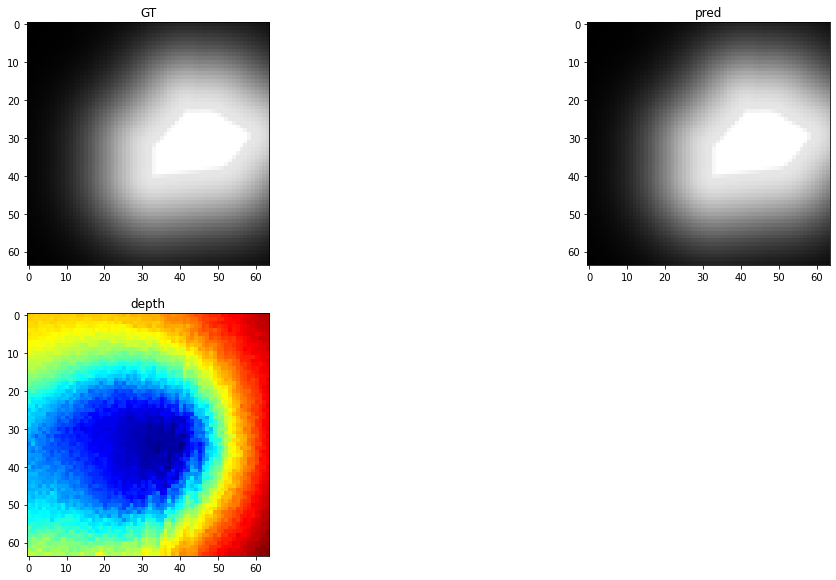

In [11]:
img_gt = torch.tensor(sample['rgbs']).view(img_wh[1], img_wh[0], 3)
img_pred = img_gt # results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10850143432617188
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


/home/gridsan/ktiwary/.conda/envs/nerf_pl/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


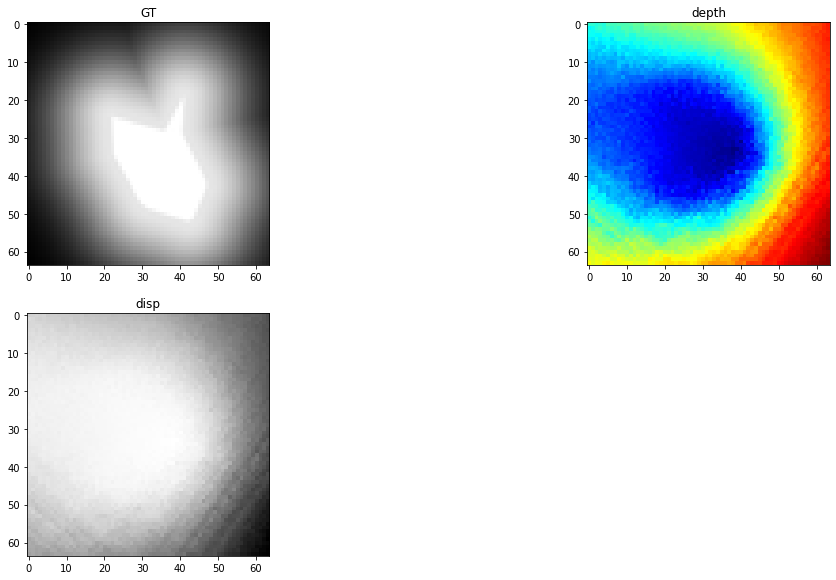

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.1016688346862793
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


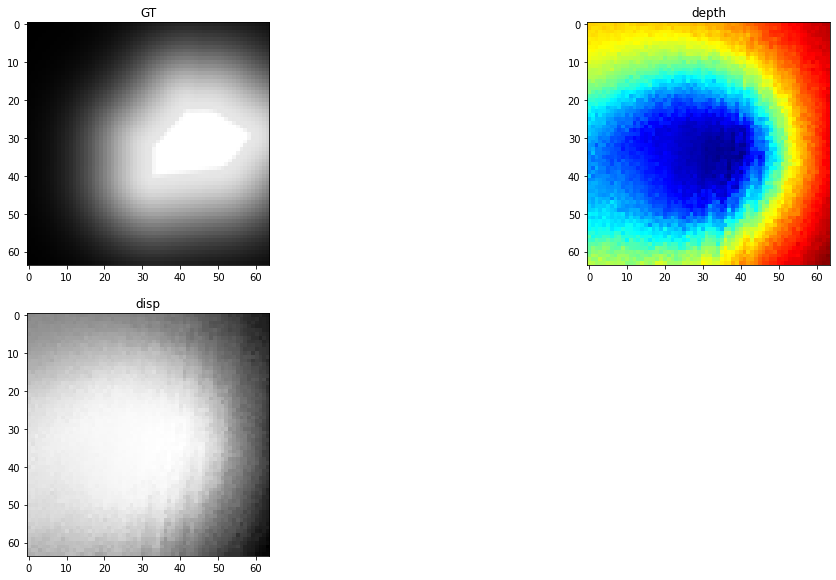

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.1002950668334961
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


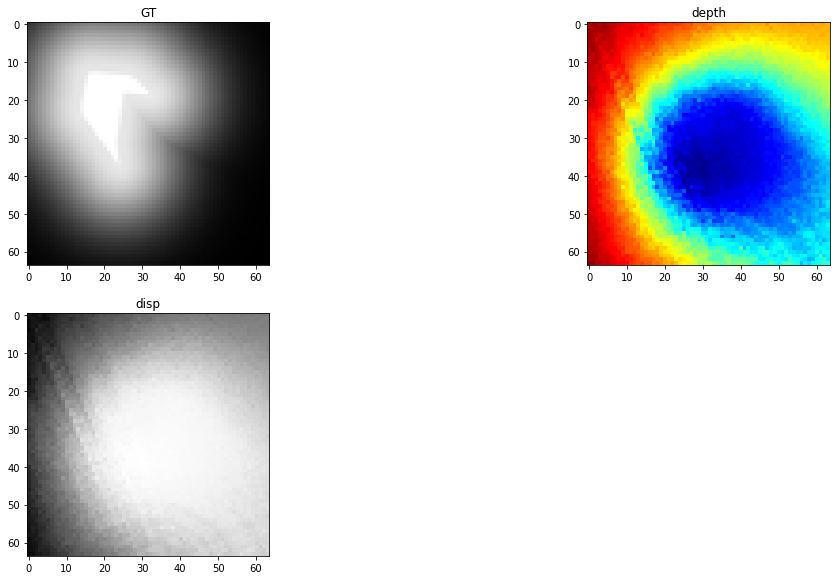

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10011625289916992
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


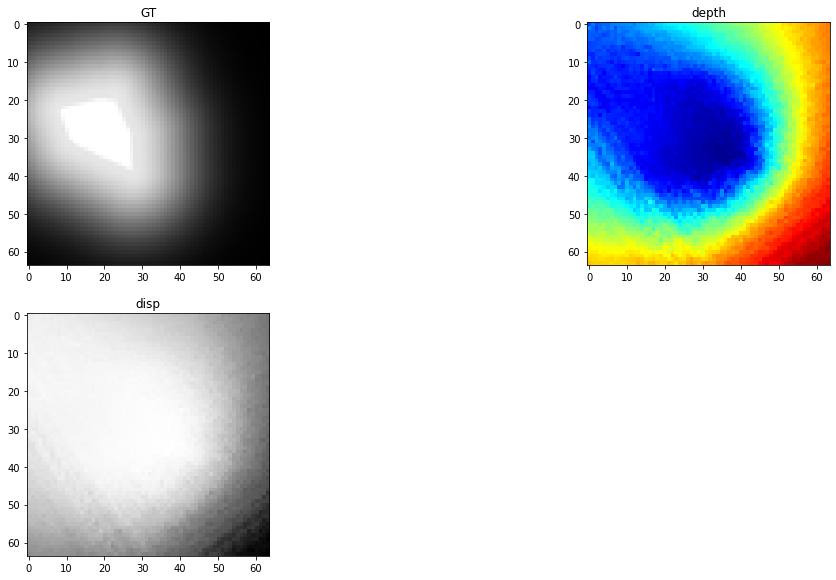

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10030341148376465
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


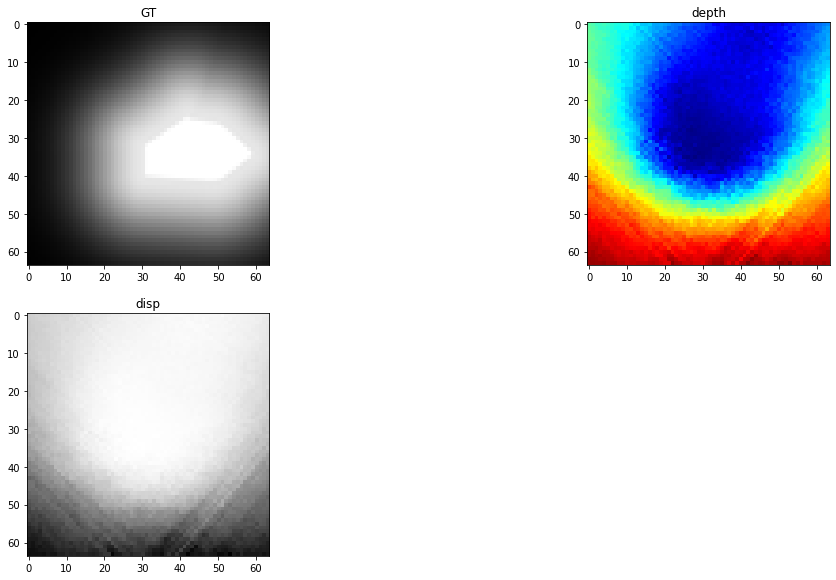

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10031890869140625
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


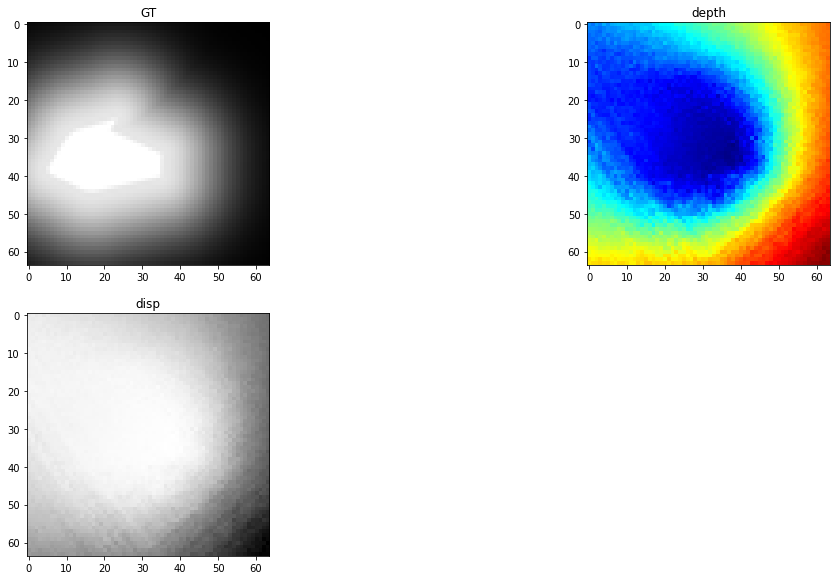

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10022759437561035
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


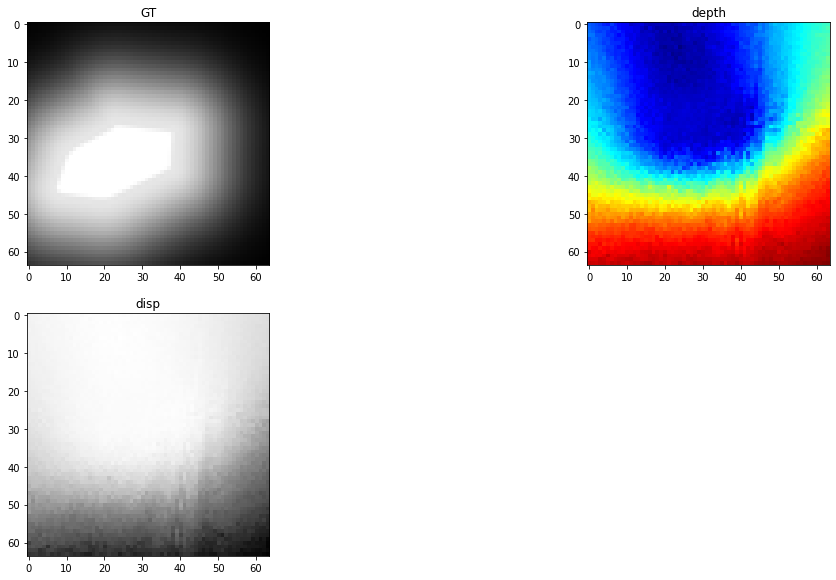

dict_keys(['rays', 'pixels', 'rgbs', 'ppc', 'light_ppc', 'light_pixels', 'light_rays'])
0.10018730163574219
tensor(1.0000) tensor(1.0000)
torch.Size([64, 64])


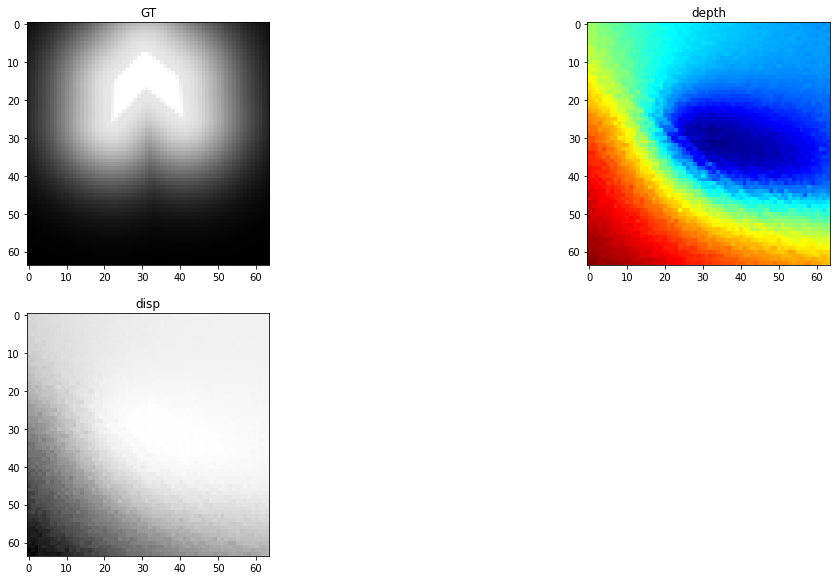

In [47]:
EPSILON = 1.0e-5
light_results = f(dataset.light_rays.cuda())
for i in range (len(dataset)):
    sample = dataset[i]
    print(sample.keys())
    # raise
    rays = sample['rays'].cuda()
    t = time.time()
    results = f(rays)
    torch.cuda.synchronize()
    print(time.time()-t)
    sm = efficient_sm(sample['pixels'].cuda(), dataset.light_pixels.cuda(),
                            results, light_results, 
                            sample['ppc'], dataset.light_ppc, 
                            image_shape=img_wh,  
                            fine_sampling=True, 
                            Light_N_importance=True, 
                            shadow_method='shadow_method_1')
    img_gt = torch.tensor(sample['rgbs']).view(img_wh[1], img_wh[0], 3)
#     print(sm.keys())
#     raise
    sm_pred = sm['rgb_fine'].cpu().view(img_wh[1], img_wh[0], 3)#.numpy()
    print(sm_pred.min(), sm_pred.max())
    depth_pred = sm['depth_fine'].view(img_wh[1], img_wh[0])
    depth = visualize_depth(depth_pred).permute(1,2,0)
    disp = 1/(depth_pred + EPSILON)
#     disp = visualize_depth(disp).permute(1,2,0) //
    print(disp.shape)
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(221)
    plt.title('GT')
    plt.imshow(img_gt)
    plt.subplot(222)
    plt.title('depth')
    plt.imshow(depth)
    plt.subplot(223)
    plt.title('disp')
    plt.imshow(disp.cpu().numpy(), cmap='Greys')
    plt.show()

In [25]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w

In [26]:
render_poses = torch.stack([pose_spherical(angle, -60., 50.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)



In [ ]:
for i in range (render_poses.shape[0]):
    rays = 
    print(sample.keys())
    # raise
    rays = sample['rays'].cuda()

    t = time.time()
    results = f(rays)
    torch.cuda.synchronize()
    print(time.time()-t)
    img_gt = torch.tensor(sample['rgbs']).view(img_wh[1], img_wh[0], 3)
    depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
    disp = 1/(depth_pred + EPSILON)
    disp = normalize_min_max(disp)
    print(disp.shape)
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(221)
    plt.title('GT')
    plt.imshow(img_gt)
    plt.subplot(222)
    plt.title('depth')
    plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
    plt.subplot(223)
    plt.title('disp')
    plt.imshow(disp.cpu().numpy(), cmap='Greys')
    plt.show()



In [24]:
# !cat ../datasets/volumetric/results_500_v2/transforms.json